# Problem
We want to use quadratic finite elements over
$$ \Omega = \big [-\frac{1}{2},\frac{1}{2} \big ]^2 $$
to solve the vector valued PDE:

\begin{alignat*}{2}
  -\Delta u_1 + u_1 &= f_1~,\qquad & \nabla u_1\cdot n=0~, \\
  -\Delta u_2 + u_2 &= f_2~,\qquad & \nabla u_2\cdot n=g~.
\end{alignat*}
where $f_1,f_2,g$ are chosen so that
$$ u_1 = \sin(\pi x) + \sin(\pi y)~,\qquad
   u_2 = \sin(4\pi x\cdot x)~. $$

## Necessary imports

In [1]:
import numpy as np

from dune.grid import cartesianDomain
from dune.alugrid import aluConformGrid as leafGridView

from ufl import SpatialCoordinate, sin, sqrt, dot
from ufl import as_vector
from ufl import TrialFunction, TestFunction
from ufl import grad, div, inner, dx, pi
from ufl import FacetNormal, ds

from dune.fem.space import lagrange
from dune.fem.scheme import galerkin
from dune.fem.plotting import plotPointData as plot

from dune.fem import integrate

## Setup of grid and space
We want to setup a quadratic finite element space $V_h$ over $\mathcal{T}_h$.

In [2]:
domain = cartesianDomain([-0.5,-0.5],[0.5,0.5],[4,4])
view = leafGridView(domain)
space = lagrange(view, order=2, dimRange=2)

x,n = SpatialCoordinate(space), FacetNormal(space)
u,v = TrialFunction(space), TestFunction(space)

The exact solution is given by $u = (u_1,u_2)^T$.

In [3]:
exact = as_vector( [sin(pi*x[0]) + sin(pi*x[1]),
                    sin(4*pi*dot(x,x))] )

The weak form is given by
\begin{alignat*}{2}
 a(u,v) &= \int_{\Omega} \nabla u \nabla v + u v \, dx \\
   b(v) &= \int_{\Omega} (\Delta u_1 + u_1) v_1 \, dx
         + \int_{\Omega} (\Delta u_2 + u_2) v_2 \, dx
         + \int_{\Omega} (\nabla u_2 \cdot n) v_2 \, ds
\end{alignat*}


In [4]:
a  = inner( grad(u), grad(v) ) * dx + dot(u,v) * dx
b  = (-div(grad(exact[0])) + exact[0]) * v[0] * dx
b += (-div(grad(exact[1])) + exact[1]) * v[1] * dx
b += dot(grad(exact[1]),n) * v[1] * ds

By default the scheme uses a _gmres_ solver but the given bilinear form
is symmetric so we can use _cg_ instead:

In [5]:
scheme = galerkin(a==b, solver="cg")

DUNE-INFO: Scheme (rebuilding)


Create $u_h \in V_h$.

In [6]:
uh = space.interpolate([0,0], name="solution")

DUNE-INFO: Compiling UFLLocalFunction (new)


Refine the grid a few times and on each level compute the solution and
compute the errors
$$ \|e_h\|_0^2 := \int_\Omega |e_h|^2~,\qquad
   \|e_h\|_1^2 := \int_\Omega |\nabla e_h|^2~. $$

In [7]:
for l in range(3):
    view.hierarchicalGrid.globalRefine(2)
    scheme.solve(target=uh)
    error = uh-exact
    h1Error = as_vector( [inner(error,error),
               inner(grad(error),grad(error))] )

    print(view.size(0), space.size,
            np.sqrt( integrate(h1Error, view, order=5) )
         )

DUNE-INFO: Compiling UFLLocalFunction (new)


128 578 [0.01040168 0.60037702]
512 2178 [0.00181493 0.21224711]
2048 8450 [0.00024122 0.05405574]


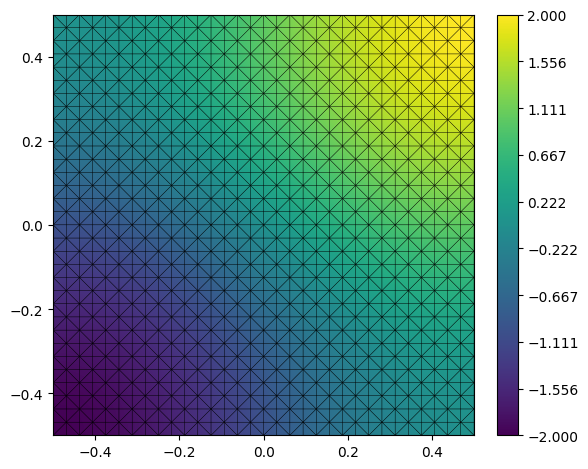

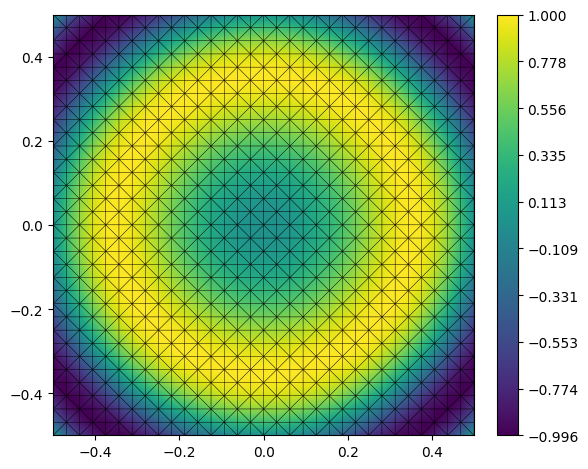

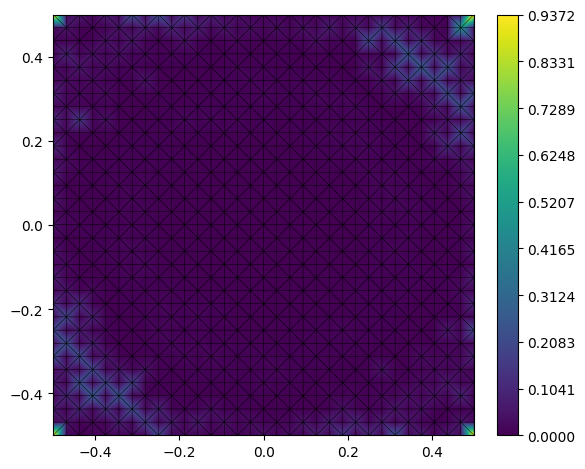

In [ ]:
plot(uh[0])
plot(uh[1])

error_function = space.interpolate(h1Error, name="error")
plot(error_function[1])